# U-Net

In [1]:
import os
import random
import numpy as np
import jax
import flax.linen as nn
from jax import grad, value_and_grad
import jax.numpy as jnp
from flax.core.frozen_dict import freeze
import optax
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
from flax.training import train_state, checkpoints
from colormaps import create_ade20k_label_colormap
import augmax
import orbax.checkpoint as orbax
from unet_model import _unet
from loss_functions import dice_loss, dice_loss_and_preds
from preprocessing_functions import prep_data_batch, create_infinite_generator, grads_vanished_or_exploded
from plotting_functions import plot_pred_and_target
import nest_asyncio
nest_asyncio.apply()

In [2]:
dataset = load_dataset("scene_parse_150")
train_dataset, test_dataset, val_dataset  = dataset["train"], dataset["test"], dataset["validation"]
# Number of segmentation classes
num_classes = 151
# Image height and width
height, width = 256, 256
# Location for saving and loading checkpoints
checkpoint_dir = "./checkpoints/unet/"
os.makedirs(checkpoint_dir, exist_ok=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Create the model object
unet = _unet(num_classes)
# Display the model details
dummy_x = np.array(train_dataset[0]["image"])
# Downsample the image
dummy_x = jax.image.resize(dummy_x, shape=(height, width, 3), method="bilinear")
rng_key = jax.random.PRNGKey(64)

In [4]:
augment_images = jax.jit(augmax.Chain(
  augmax.RandomContrast(range=(0, 0.3), p=1.0),
  augmax.RandomBrightness(range=(-0.6, 0.6), p=1.0),
))

Epoch: 0
		Validation Loss: 0.42


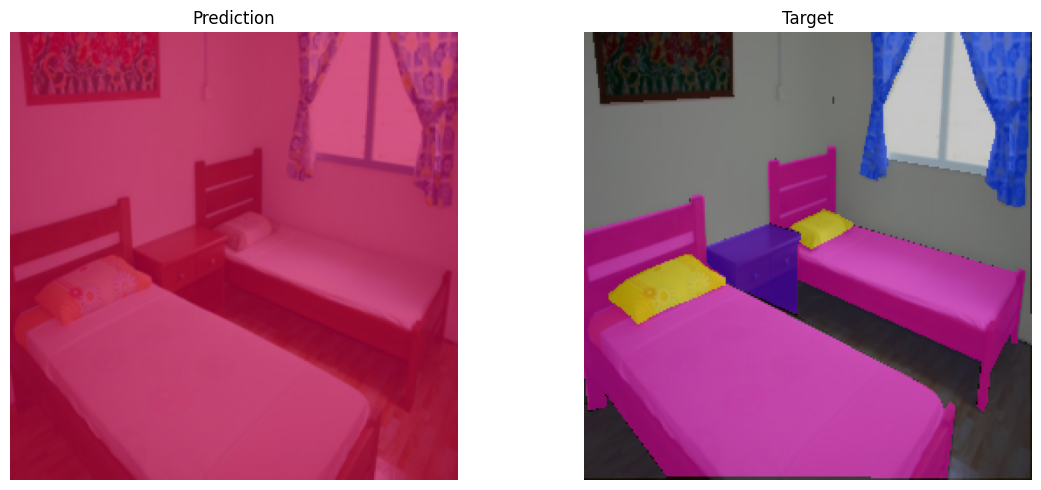

	Loss: 0.46
Gradients have vanished or exploded, exiting training run now...


In [5]:
# Number of training epochs
epochs = 500
# Display training loss frequency
print_freq = 100
# Validation frequency
val_epochs = 100
# Checkpointing frequency
save_steps = 1000
batch_size = 1
# A small number to prevent loss function from dividing by zero
epsilon = 0.0001
# Exponential decay learning rate schedule defined by:
# learning_rate * decay_rate ^ (global_step / decay_steps)
schedule = optax.exponential_decay(
    init_value=0.01,
    transition_steps=100,
    decay_rate=0.99,
    transition_begin=1000,
    end_value=0.0001,
)
optimizer = optax.adam(learning_rate=schedule)

# Restore latest checkpoint
restore_latest = True
orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())

variables = unet.init(rng_key, dummy_x)
state = train_state.TrainState.create(
    apply_fn=unet.apply,
    params=variables['params'], 
    tx=optimizer,
)

if restore_latest:
    state = checkpoints.restore_checkpoint(
        ckpt_dir=checkpoint_dir, 
        target=state, 
        orbax_checkpointer=orbax_checkpointer
    )

train_data_generator = create_infinite_generator(train_dataset)
val_data_generator = create_infinite_generator(val_dataset)

losses = []
val_losses = []

for epoch in range(epochs + 1):
    if epoch % print_freq == 0: print(f"Epoch: {epoch}")
    # Evaluate the models performance
    if epoch % val_epochs == 0:
        # Prepare a batch of data
        val_inputs = []
        # Loop until a valid batch is found
        while len(val_inputs) == 0:
            val_inputs, val_targets = prep_data_batch(val_data_generator, batch_size, height, width, num_classes)
        # Perform augmentation
        rng_key, subkey = jax.random.split(rng_key)
        val_inputs = augment_images(subkey, val_inputs)
        # Get loss and preds
        variables = freeze({"params": state.params})
        val_loss, val_preds = dice_loss_and_preds(variables, state, val_inputs, val_targets, epsilon)
        val_losses.append(val_loss)
        print(f"\t\tValidation Loss: {val_loss :.2f}")
        # Plot the segmentation predictions
        for val_index in range(batch_size):
            val_input = val_inputs[val_index]
            val_pred = val_preds[val_index]
            plot_pred_and_target(val_input, val_pred, val_targets[val_index])

    # Prepare a batch of data
    inputs = []
    # Loop until a valid batch is found
    while len(inputs) == 0:
        inputs, targets = prep_data_batch(train_data_generator, batch_size, height, width, num_classes)
    # Perform augmentation
    rng_key, subkey = jax.random.split(rng_key)
    inputs = augment_images(subkey, inputs)
    # Perform backpropagation 
    variables = freeze({"params": state.params})
    loss, grads = value_and_grad(dice_loss, argnums=0)(variables, state, inputs, targets, epsilon)
    state = state.apply_gradients(grads=grads["params"])

    losses.append(loss)
    last_mean_loss = np.array(losses[-print_freq:]).mean()
    if epoch % print_freq == 0: print(f"\tLoss: {last_mean_loss :.2f}")
    

    if grads_vanished_or_exploded(grads):
        print("Gradients have vanished or exploded, exiting training run now...")
        break

    if epoch % save_steps == 0 and epoch != 0:
        checkpoints.save_checkpoint(
            ckpt_dir=checkpoint_dir, 
            target=state, 
            step=epoch,
            overwrite=True,
            keep=10,
            orbax_checkpointer=orbax_checkpointer
            )


    